## Dataset exploration 

This notebook glimpses into the structure of the MS COCO Captions dataset. Some examples of the images and associated labels and metadata can be seen. Furthermore, the notebook implements the sorting of the images into categories.

WARNING: It only uses the validstion split of the dataset to avoid extremely large downloads. 

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
import json
import os
from pycocotools.coco import COCO
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import imageio as iio
import urllib.request
import zipfile

### Explore COCO

In [12]:
# WARNING: potentially large download ahead

# check is the required images and annotation files
domains_list = [
    "zips/val2014.zip", 
    "annotations/annotations_trainval2014.zip",
]
for domain in domains_list:
    file_path_full = os.path.join("../../../data/val", domain)
    # strip the filename suffix to create subdirectory first
    file_name_strip = domain.split("/")[0]
    # Filepath for saving the file downloaded from the internet.
    file_path = os.path.join("../../../data/val", file_name_strip)
    
    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path_full):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists("../../../data/val"):
            os.makedirs("../../../data/val")
        if not os.path.exists(file_path):
            os.makedirs(file_path)    

        # Download the file from the internet.
        url = "http://images.cocodataset.org/" + domain
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=str(file_path_full),
                                                 )

        print("Download of ", domain, " finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall("../../../data/val")
    else:
        print("Data ", domain, " has apparently already been downloaded and unpacked or has an unknow compression format.")

Data  zips/val2014.zip  has apparently already been downloaded and unpacked or has an unknow compression format.
Data  annotations/annotations_trainval2014.zip  has apparently already been downloaded and unpacked or has an unknow compression format.


Below, the format of the annotation files is explored.

There are three types of annotation files:
* prefixed with "captions"
* prefixed with "instances"
* prefixed with "person_keypoints"

Only first two files are of interest for captioning. The first file contains the image captions along with othe meta information, while the second file contains category information about each image along with meta information.

Below, the files are loaded and explored for better undersranding of their structure. A helpful resource reviewing that is also [here](https://towardsdatascience.com/getting-started-with-coco-dataset-82def99fa0b8).

In [19]:
# json containing actual captions
with open("../../../data/val/annotations/captions_val2014.json") as f:
    captions = json.load(f)

In [20]:
captions.keys()

dict_keys(['info', 'images', 'licenses', 'annotations'])

In [21]:
print("Number of caption instances in the 2014 validation split: ", len(captions['annotations']))

Number of caption instances in the 2014 validation split:  202654


In [22]:
print("Number of images in the 2014 validation split: ", len(captions['images']))

Number of images in the 2014 validation split:  40504


In [23]:
# example caption 
captions["annotations"][0]

{'image_id': 203564,
 'id': 37,
 'caption': 'A bicycle replica with a clock as the front wheel.'}

In [24]:
# example image information
captions["images"][0]

{'license': 3,
 'file_name': 'COCO_val2014_000000391895.jpg',
 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg',
 'height': 360,
 'width': 640,
 'date_captured': '2013-11-14 11:18:45',
 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
 'id': 391895}

In [27]:
# misc meta information contained in the file
captions["licenses"]
captions["info"]

{'description': 'COCO 2014 Dataset',
 'url': 'http://cocodataset.org',
 'version': '1.0',
 'year': 2014,
 'contributor': 'COCO Consortium',
 'date_created': '2017/09/01'}

In [29]:
# json containing segmentation, bounding boxes, category ID info
with open("../../../data/val/annotations/instances_val2014.json") as f:
    categories = json.load(f)

In [30]:
categories.keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

In [31]:
print("Number of category annotations in 2014 validation split: ", len(categories['annotations']))
print("Number of images in the categories file in the 2014 validation split: ", len(categories['images']))
print("Number of distinct categories used in the anotations: ", len(categories["categories"]))

Number of category annotations in 2014 validation split:  291875
Number of images in the categories file in the 2014 validation split:  40504
Number of distinct categories used in the anotations:  80


In [40]:
# example category
print(categories['categories'][0])
print()
# get distinct supercategories
supercats = [x['supercategory'] for x in categories["categories"]]
print(f"Number of supercategories: {len(set(supercats))} . \nSupercategories: ", set(supercats))
print()

# get distinct subcategories
subcats = [x['name'] for x in categories["categories"]]
print(f"Number of subcategories: {len(set(subcats))} . \nSubcategories: ", set(subcats))
print()

{'supercategory': 'person', 'id': 1, 'name': 'person'}

Number of supercategories: 12 . 
Supercategories:  {'outdoor', 'sports', 'food', 'indoor', 'vehicle', 'animal', 'electronic', 'person', 'accessory', 'furniture', 'kitchen', 'appliance'}

Number of subcategories: 80 . 
Subcategories:  {'tie', 'boat', 'mouse', 'fork', 'toilet', 'orange', 'donut', 'banana', 'vase', 'couch', 'keyboard', 'cell phone', 'skis', 'zebra', 'microwave', 'wine glass', 'motorcycle', 'cake', 'bear', 'potted plant', 'tennis racket', 'bed', 'tv', 'parking meter', 'apple', 'airplane', 'cat', 'book', 'sandwich', 'broccoli', 'hot dog', 'bench', 'knife', 'carrot', 'hair drier', 'toothbrush', 'umbrella', 'elephant', 'bird', 'traffic light', 'skateboard', 'sheep', 'person', 'snowboard', 'laptop', 'bowl', 'chair', 'sink', 'cup', 'pizza', 'oven', 'handbag', 'kite', 'sports ball', 'bottle', 'suitcase', 'horse', 'baseball glove', 'scissors', 'car', 'remote', 'dining table', 'clock', 'backpack', 'spoon', 'fire hydrant', 'ba

In [41]:
# image annotations look just like in the captions file
# example category annotation
categories['annotations'][0]

{'segmentation': [[239.97,
   260.24,
   222.04,
   270.49,
   199.84,
   253.41,
   213.5,
   227.79,
   259.62,
   200.46,
   274.13,
   202.17,
   277.55,
   210.71,
   249.37,
   253.41,
   237.41,
   264.51,
   242.54,
   261.95,
   228.87,
   271.34]],
 'area': 2765.1486500000005,
 'iscrowd': 0,
 'image_id': 558840,
 'bbox': [199.84, 200.46, 77.71, 70.88],
 'category_id': 58,
 'id': 156}

### Plan

1. Install and get familiar with pycocotools: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb
2. Plot a couple of examples of a record
3. Figure out a way to filter by category
4. Figure out a way to transform this into a tfds instance
5. Prepare corresponding scripts

#### Example from pycocotools tutorial https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

### Explore the images and captions

Below, the pycocotools API is used to conveniently take a look at some images annotated with different categories, as well as their captions.

Pycocotools can be installed with `pip install pycocotools`.

In [42]:
# load annotation file
coco = COCO("../../../data/val/annotations/instances_val2014.json")

# display categories (80, used for object detection or segmentation) and supercategories (12)
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))


loading annotations into memory...
Done (t=3.68s)
creating index...
index created!
COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
outdoor sports food indoor vehicle animal electronic person accessory furniture kitchen appliance


In [47]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person', 'dog', 'skateboard']); # ,'skateboard', ,'dog'
imgIds = coco.getImgIds(catIds=catIds );
print(len(catIds), " ", catIds)
print(len(imgIds), " ", imgIds)

3   [1, 18, 41]
19   [438915, 209028, 500100, 372874, 282768, 360595, 366484, 449560, 28842, 241837, 324158, 231240, 493020, 547421, 549220, 255209, 353644, 279278, 45175]


In [43]:
# insert a random image ID from the ones displayed above for the given categories, in order to display it along with captions
imgIds = coco.getImgIds(imgIds = [45175])
print(imgIds)
img = coco.loadImgs(imgIds)[0]
img

[45175]


{'license': 4,
 'file_name': 'COCO_val2014_000000045175.jpg',
 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000045175.jpg',
 'height': 426,
 'width': 640,
 'date_captured': '2013-11-18 10:55:19',
 'flickr_url': 'http://farm3.staticflickr.com/2188/2273154848_bbd217868d_z.jpg',
 'id': 45175}

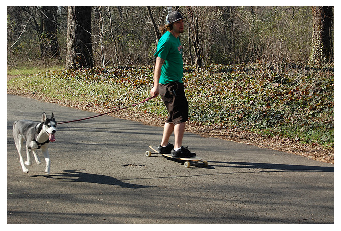

In [44]:
# load and display example image
I = iio.imread('../../../data/val/val2014/%s'%(img['file_name']))
# use url to load image
# I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
[222259, 242536, 255565, 255925, 257224]
[{'image_id': 45175, 'id': 222259, 'caption': 'a man riding a skateboard with his dog.'}, {'image_id': 45175, 'id': 242536, 'caption': 'A man on a skateboard walks a dog on a leash.'}, {'image_id': 45175, 'id': 255565, 'caption': 'A boy on a skateboard walking a dog on a pavement.'}, {'image_id': 45175, 'id': 255925, 'caption': 'A man skateboarding while walking his dog. '}, {'image_id': 45175, 'id': 257224, 'caption': 'A man walking his dog while riding a skateboard'}]
a man riding a skateboard with his dog.
A man on a skateboard walks a dog on a leash.
A boy on a skateboard walking a dog on a pavement.
A man skateboarding while walking his dog. 
A man walking his dog while riding a skateboard


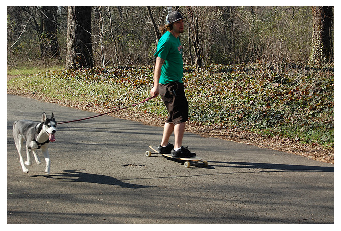

In [45]:
# initialize COCO api for caption annotations
coco_caps=COCO("../../../data/val/annotations/captions_val2014.json")

# load and display caption annotations for the selected image
annIds = coco_caps.getAnnIds(imgIds=img['id']);
print(annIds)
anns = coco_caps.loadAnns(annIds)
print(anns)

coco_caps.showAnns(anns)
plt.imshow(I); plt.axis('off'); plt.show()


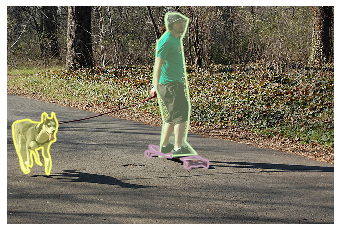

In [48]:
# load and display keypoint annotations, just for exploration
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

#### Try loading entire dataset

In [39]:
# convenience functions making loading the ds easier are implemented as separate module: 
# https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/coco.py

Options for dealing with the dataset:
* use an analogous util script with standard records lists / dicts
* use keras utility functions for loading data: https://www.tensorflow.org/tutorials/text/image_captioning?hl=nl
* use a util script returning tfds instance
    * how do I construct data points form separate image and annotation files?

Crucial decision criterion: what is the most suitable format for feeding the data it into the keras.ResNet50 pretrained model and tf.keras.layers.LSTM layer? 
    * yes, just use straight up tfds format in cifar10 tf example
    * https://keras.io/examples/vision/image_captioning/

In [ ]:
# batching

### Convenience scripts for loading and preparing dataset
From keras tutorial: https://keras.io/examples/vision/image_captioning/
and tensorflow tutorial: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb, https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/coco.py

In [11]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras.applications import efficientnet
#from tensorflow.keras.layers import TextVectorization

seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)

# from .. import utils #as download
# from . import utils
import download

Download dataset from cocodataset.org:
* use convenience functions in utils.download
* put in data directories, both images and annotations
* create tfds with convenience function

In [ ]:
base_url = "https://cocodataset.org"
filenames = ["zips/val2014.zip",
                 "annotations/annotations_trainval2014.zip"]
# download
for filename in filenames:
    download.maybe_download_an_extract(
        base_url=base_url,
        filename=filename,
        download_dir="../../data/")
    

In [ ]:
# find out max caption length
# decide on vocab size